## Libraries and Dependencies

In [1]:
import torch
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.stats import norm
from scipy.stats import ncx2  # 非中心卡方分布
from pyDOE import lhs
import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

import warnings
warnings.filterwarnings('ignore')

np.random.seed(1234)

In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## Physics-informed Neural Networks

In [3]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1 #神经网络的层数
        
        # set up layer order dict
        self.activation = torch.nn.Tanh #激活函数为tanh
        
        layer_list = list() # 创建一个空列表 layer_list，用于存储神经网络的层和激活函数。
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        ) # 向 layer_list 添加输出层
        layerDict = OrderedDict(layer_list) #存储按顺序排列的层和激活函数
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

In [4]:
# the physics-guided neural network
class PhysicsInformedNN():
    def __init__(self, X_u, u, X_f, layers, lb, ub, sigma, r,gamma):
        
        # boundary conditions
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        self.S_u = torch.tensor(X_u[:, 0:1], requires_grad=True).float().to(device)
        self.t_u = torch.tensor(X_u[:, 1:2], requires_grad=True).float().to(device)
        self.S_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        
        self.layers = layers
        self.sigma = sigma
        self.r = r
        self.gamma = gamma

        # deep neural networks
        self.dnn = DNN(layers).to(device)
        
        # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )

        self.iter = 0
        self.loss_history = []
        self.time_history = []
        
    def net_u(self, S, t):  
        u = self.dnn(torch.cat([S, t], dim=1)) # dim = 1 :按行并排
        return u
    
    def net_f(self, S, t):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(S, t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_S = torch.autograd.grad(
            u, S, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_SS = torch.autograd.grad(
            u_S, S, 
            grad_outputs=torch.ones_like(u_S),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = u_t + 0.5 * self.sigma**2 * S**(2*self.gamma) * u_SS + self.r * S * u_S - self.r * u
        return f
    
    def loss_func(self):
        self.optimizer.zero_grad()
        
        u_pred = self.net_u(self.S_u, self.t_u)
        f_pred = self.net_f(self.S_f, self.t_f)
        loss_u = torch.mean((self.u - u_pred) ** 2)
        loss_f = torch.mean(f_pred ** 2)
        
        loss = loss_u + loss_f
        
        loss.backward()
        self.iter += 1
        if self.iter % 100 == 0:
            print(
                'Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e' % (self.iter, loss.item(), loss_u.item(), loss_f.item())
            )
        self.loss_history.append(loss.item())
        self.time_history.append(time.time())
        return loss
    
    def train(self):
        self.dnn.train()
                
        # Backward and optimize
        self.optimizer.step(self.loss_func)

            
    def predict(self, X):
        S = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(S, t)
        f = self.net_f(S, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

In [5]:
def cev_put_option(S, K, T, t, r, sigma0, beta):
    tau = T - t
    if np.any(tau == 0):
        return np.maximum(K - S, 0)  # 到期时间直接返回 payoff
    
    delta_sq = sigma0**2 * np.power(S, 2 - beta)
    if np.any(delta_sq <= 0):
        raise ValueError("Invalid delta_sq: Ensure S > 0 and beta is well-defined.")
    
    d = (2 * r) / (delta_sq * (2 - beta) * (np.exp(r * (2 - beta) * tau) - 1))
    x = np.power(S, 2 - beta) * np.exp(r * (2 - beta) * tau) * d
    y = np.power(K, 2 - beta) * d

    def Q(w, v, lambd):
        return ncx2.cdf(w, v, lambd)
    
    x = np.clip(x, 1e-10, None)
    y = np.clip(y, 1e-10, None)

    if beta < 2:
        price = (
            K * np.exp(-r * tau) * Q(2 * x, 2 / (2 - beta), 2 * y)
            - S * (1 - Q(2 * y, 2 + 2 / (2 - beta), 2 * x))
        )
    elif beta > 2:
        price = (
            K * np.exp(-r * tau) * Q(2 * y, 2, 2 / (beta - 2) * x)
            - S * (1 - Q(2 * x, 2 / (beta - 2), 2 * y))
        )
    else:
        raise ValueError("β = 2 的情况不适用 CEV 模型")

    return price


## Configurations

In [9]:
# Parameters for Black-Scholes equation
sigma = 0.2
r = 0.05
gamma = 0.5
T = 1.0  # 到期时间
K = 50  # 执行价格
N = 100
M = 10000

# Domain bounds for stock price and time
S_min = 0.0
S_max = 100.0
t_min = 0.0
t_max = T

# Generating training data
N_u = 1000  # Number of initial condition points
N_f = 10000  # Number of collocation points

# Initial condition: European Call Option Payoff at t = T
S_0 = np.linspace(S_min, S_max, N_u)[:, None]
t_0 = np.ones((N_u, 1))
u_0 = np.maximum(K - S_0, 0)

# Collocation points
X_f_train = np.hstack((S_min + (S_max - S_min) * lhs(1, N_f), t_min + (t_max - t_min) * lhs(1, N_f)))

# Combine all training data
X_u_train = np.hstack([S_0, t_0])
u_train = u_0

# Randomly sample initial condition points
idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
X_u_train = X_u_train[idx, :]
u_train = u_train[idx, :]

# Define the neural network structure
layers = [2, 20, 20, 20, 20,20,20,20, 1]

## Training

In [10]:
# Initialize the Physics Informed Neural Network
model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, [S_min, t_min], [S_max, t_max], sigma, r,gamma)

In [11]:
# Train the model

start_time = time.time()
model.train()
elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))

Iter 100, Loss: 1.63671e+00, Loss_u: 1.30850e+00, Loss_f: 3.28210e-01
Iter 200, Loss: 6.01912e-01, Loss_u: 4.09121e-01, Loss_f: 1.92791e-01
Iter 300, Loss: 2.25716e-01, Loss_u: 1.75663e-01, Loss_f: 5.00530e-02
Iter 400, Loss: 1.75268e-01, Loss_u: 1.39472e-01, Loss_f: 3.57960e-02
Iter 500, Loss: 1.43948e-01, Loss_u: 1.14491e-01, Loss_f: 2.94570e-02
Iter 600, Loss: 1.35348e-01, Loss_u: 1.09627e-01, Loss_f: 2.57209e-02
Iter 700, Loss: 1.22657e-01, Loss_u: 9.74713e-02, Loss_f: 2.51859e-02
Iter 800, Loss: 1.03533e-01, Loss_u: 8.68040e-02, Loss_f: 1.67290e-02
Iter 900, Loss: 9.92967e-02, Loss_u: 8.59856e-02, Loss_f: 1.33112e-02
Iter 1000, Loss: 9.03539e-02, Loss_u: 7.62041e-02, Loss_f: 1.41498e-02
Iter 1100, Loss: 8.31188e-02, Loss_u: 7.18881e-02, Loss_f: 1.12307e-02
Iter 1200, Loss: 7.32191e-02, Loss_u: 6.44720e-02, Loss_f: 8.74707e-03
Training time: 19.1118


In [12]:
# Predict using the trained model
S_star = np.linspace(S_min, S_max, 100)[:, None]
t_star = np.linspace(t_min, t_max, 100)[:, None]
S_star, t_star = np.meshgrid(S_star, t_star)
X_star = np.hstack((S_star.flatten()[:, None], t_star.flatten()[:, None]))

u_pred, f_pred = model.predict(X_star)

# Compute exact solution
u_exact = cev_put_option(S_star.flatten(), K, T, t_star.flatten(), r, sigma, gamma)

# Compute error
error_u = np.linalg.norm(u_exact - u_pred.flatten(), 2) / np.linalg.norm(u_exact, 2)
print('Error u: %e' % (error_u))

# Reshape predictions and exact solutions for plotting
U_pred = griddata(X_star, u_pred.flatten(), (S_star, t_star), method='cubic')
U_exact = griddata(X_star, u_exact.flatten(), (S_star, t_star), method='cubic')
Error = np.abs(U_exact - U_pred)

Error u: 4.870973e-02


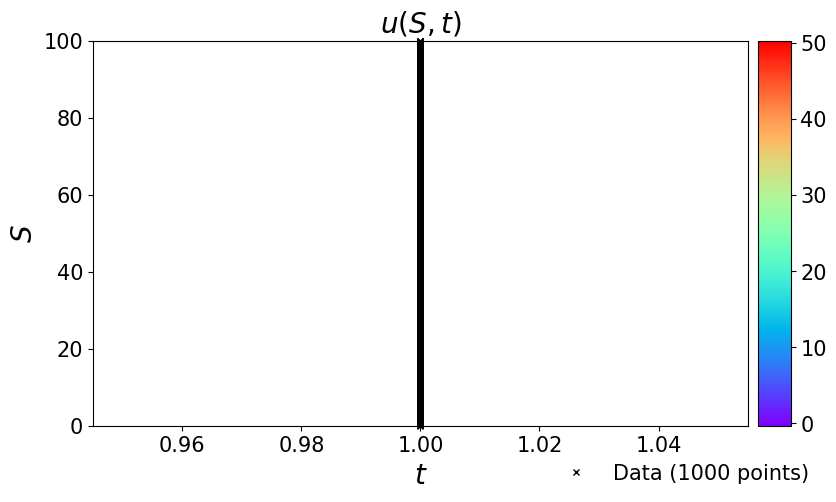

In [14]:

""" The aesthetic setting has changed. """

####### Row 0: u(S,t) ##################    

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t_0.min(), t_0.max(), S_0.min(), S_0.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(
    X_u_train[:,1], 
    X_u_train[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
)

line = np.linspace(t_0.min(), t_0.max(), 2)[:,None]
ax.plot(t_0[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t_0[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t_0[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$S$', size=20)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
ax.set_title('$u(S,t)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

plt.show()

Text(0.5, 1.0, 'Error')

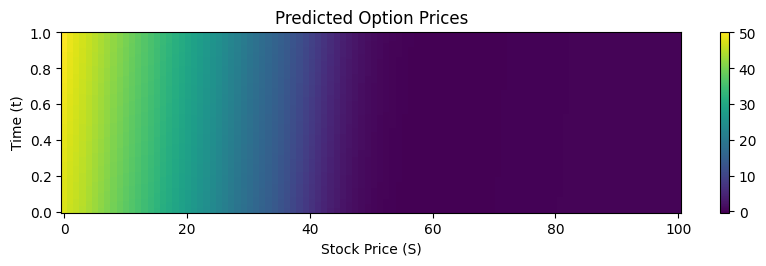

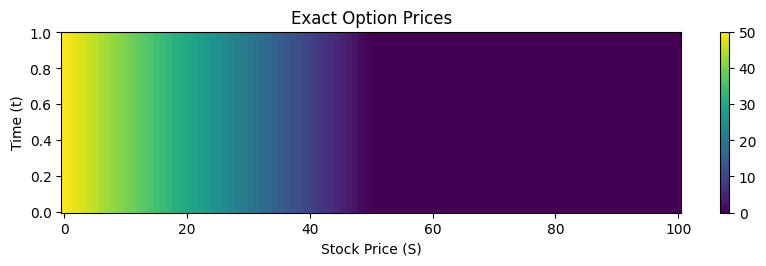

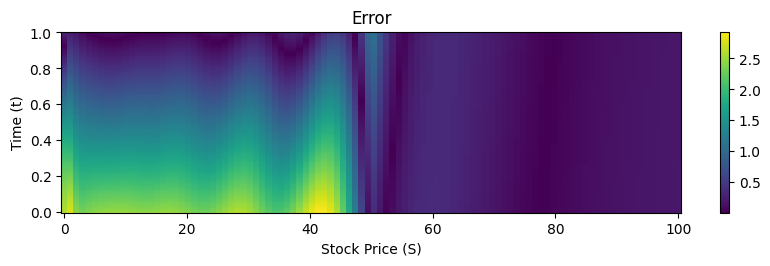

In [15]:
# Plot predicted solution
plt.figure(figsize=(10, 8))
plt.subplot(3, 1, 1)
plt.pcolor(S_star, t_star, U_pred, shading='auto')
plt.colorbar()
plt.xlabel('Stock Price (S)')
plt.ylabel('Time (t)')
plt.title('Predicted Option Prices')

# Plot predicted solution
plt.figure(figsize=(10, 8))
plt.subplot(3, 1, 1)
plt.pcolor(S_star, t_star, U_exact, shading='auto')
plt.colorbar()
plt.xlabel('Stock Price (S)')
plt.ylabel('Time (t)')
plt.title('Exact Option Prices')

# Plot error
plt.figure(figsize=(10, 8))
plt.subplot(3, 1, 3)
plt.pcolor(S_star, t_star, Error, shading='auto')
plt.colorbar()
plt.xlabel('Stock Price (S)')
plt.ylabel('Time (t)')
plt.title('Error')

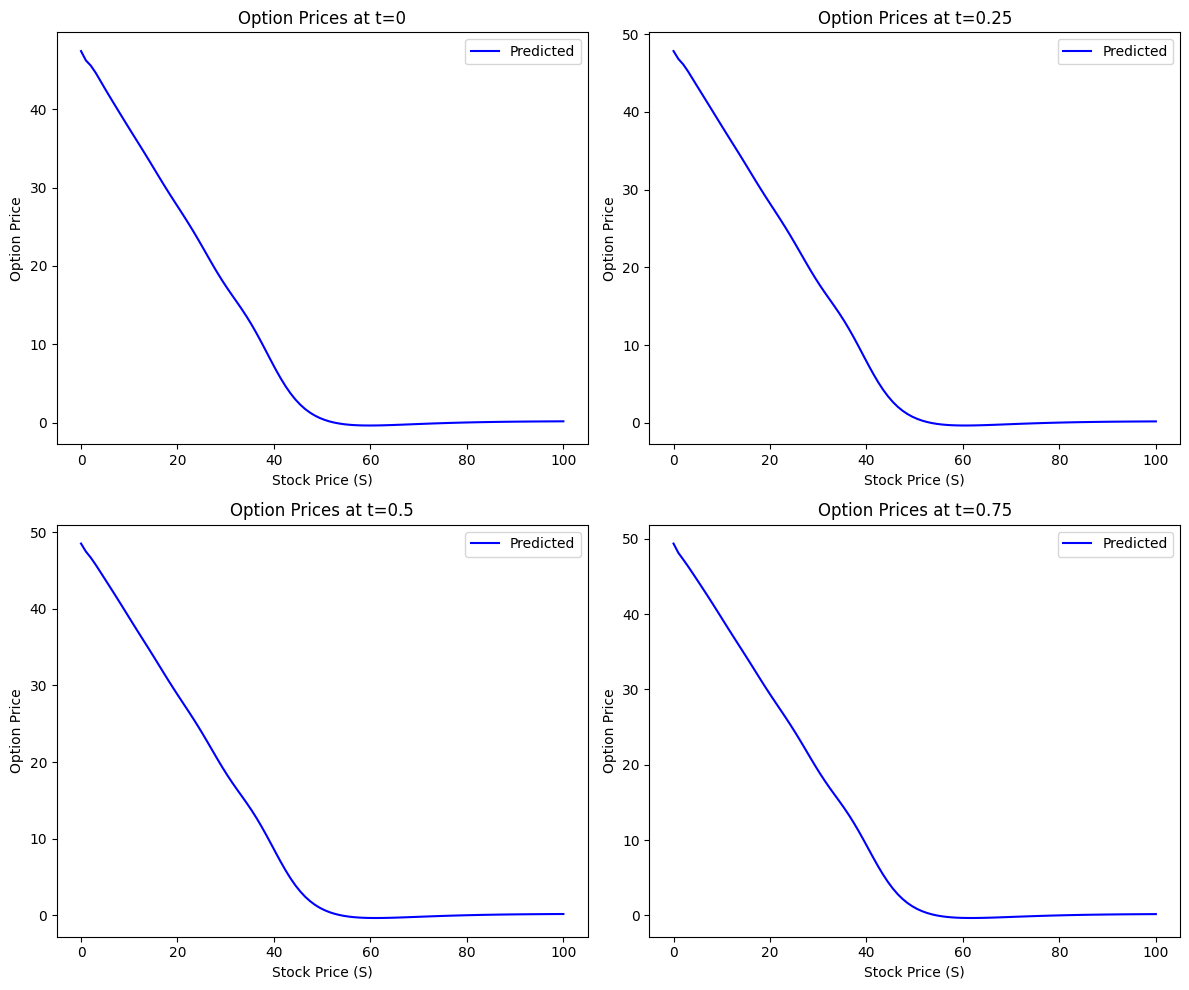

In [17]:
# Predict using the trained model for specific time slices
t_values = [0,0.25, 0.5, 0.75]
S_star = np.linspace(S_min, S_max, 100)[:, None]

plt.figure(figsize=(12, 10))

for i, t_val in enumerate(t_values):
    t_star = t_val * np.ones_like(S_star)
    X_star = np.hstack((S_star, t_star))
    
    u_pred, _ = model.predict(X_star)
    
    # Plot predicted and exact option prices in the same plot
    plt.subplot(2, 2, i + 1)
    plt.plot(S_star, u_pred, 'b-', label='Predicted')
    plt.xlabel('Stock Price (S)')
    plt.ylabel('Option Price')
    plt.title(f'Option Prices at t={t_val}')
    plt.legend()

plt.tight_layout()
plt.show()